In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

In [ ]:
#TODO: also save the general sample size version

#TODO: single sided quantile estimation
#TODO: mean estimation using fixed window, and make prediction set
#TODO: linear regression

In [2]:
#ARW functions
import numpy as np

#compute cdfhat(q)

def expand_U_tk(U):
    U_all = np.full((len(U), len(U)), np.nan)
    for i in range(len(U)):
        end_index = len(U) - i  
        U_all[i, :end_index] = U[i:]
        
    return U_all

def cdfhat(q, arr):
    count_leq = np.count_nonzero(arr <= q) 
    quantile = count_leq / len(arr)  
    return quantile

def cdfhat_arr(q, arr):
    q = q[:, np.newaxis]  # Convert q to column vector for broadcasting
    cdf_values = np.mean(arr <= q, axis=1)  # Broadcast comparison over arr and calculate mean
    return cdf_values

#compute psi_tk for all k
def compute_psi(Btk_all, alpha, delta):
    sigma_bin = alpha *(1-alpha) 

    #NOTE: this part can be changed
    psi_all = np.sqrt(2 * sigma_bin * np.log(1/delta) / Btk_all)
    #psi_1_all = 1.5 * np.sqrt(2 * sigma_bin * np.log(4/delta) / Btk_all) + (19/4) * np.log(4/delta) / Btk_all
    #psi_2_all = np.sqrt(2 * sigma_bin * np.log(4/delta) / Btk_all) + (19/6) * np.log(4/delta) / Btk_all

    return psi_all

# Compute summary statistics

def prepare(U, B_arr, alpha):
    """Compute B_tk, mu_hat_tk and v_hat_tk for all k
    Args:
        U (np.array): 1D array of length B_1 + ... + B_t
        B_arr: (np.array) stores the sample size for each period
        alpha: quantile level
        delta: exceptional probability
    Returns:
        Btk_all, qtk_all, Fti_qtk_all
    """
    t = len(B_arr)
    B_arr = np.ones(t)
    period_starts = np.arange(t)
   
    """ U_expand = expand_U_tk(U)
    qtk_all = np.nanquantile(U_expand, 1-alpha, axis=0)[::-1]
    """
    #TODO: time this
    qtk_all = np.array( [np.quantile( U[period_starts[i]:], 1-alpha, method='inverted_cdf') for i in range(t)] )[::-1]

    Fti_qtk_all = np.zeros((t,t))

    #TODO: time this; only do k>i part for qtk_all
    for i in range(t):
        Fti_qtk_all[i,i:] = cdfhat_arr(qtk_all[i:], U[period_starts[t-i-1]:])
   
    return qtk_all, Fti_qtk_all

# Goldenshluger-Lepski procedure

def ARWQE(U, B_arr, psi_all, qtk_all, Fti_qtk_all, alpha, gamma=1):

    """ Adaptive Rolling Window Mean Estimation(ARWME): selecting the best window size
    Args:
        U (np.array): 1D array of length B_1 + ... + B_t
        B_arr: (np.array) stores the sample size for each period
        alpha: quantile level
        delta: exceptional probability

    Returns:
        k_hat +1 (int): best window size
        qtk_all[k_hat] (float): best quantile estimate
    """

    t = len(B_arr)
    
    pos_arr = np.arange(1, t+1)
    pos_start = np.cumsum(pos_arr) - pos_arr

    # Compute phi_hat_k for all k
    phi_hat_all = np.empty(t)
    for k in range(t):
        k_pos = pos_start[t-1] + k
        tmp = np.array([ np.abs(Fti_qtk_all[t-1,i,k_pos] - (1-alpha)) - (psi_all[k] - psi_all[i])*gamma for i in range(k + 1) ])
        tmp[tmp < 0] = 0
        phi_hat_all[k] = np.max(tmp)

    # Choose k_hat
    k_hat = np.argmin(phi_hat_all + psi_all)
    return k_hat+1, qtk_all[t-1, k_hat]

In [3]:
def prepare_all(U, B_arr, alpha):
    num_periods = len(B_arr)
    period_ends = np.cumsum(B_arr) - 1; 
    period_starts = np.cumsum(B_arr) - B_arr
    qtk_all = np.zeros((num_periods, num_periods))

    for t in range(num_periods):
        qtk_all[t, :t+1] = np.array( [np.quantile( U[period_starts[i]:period_ends[t]+1], 1-alpha, method='inverted_cdf') for i in range(t+1)] )[::-1]

    #get lower triangular indices of qtk_all
    tril = np.tril_indices(num_periods)
    qtril = qtk_all[tril]
    B_arr_tk = np.arange(1, num_periods+1)

    #compute Fti_qtk for all t and all k
    Fti_qtk_all = empirical_cdf_vectorized(U, B_arr, qtril)
    return qtk_all, Fti_qtk_all

In [194]:
import numpy as np

def empirical_cdf_vectorized(U, B_arr, qs):

    boundaries = np.cumsum(B_arr)
    starts = boundaries - B_arr 
    
    # Prepare a binary matrix: rows are thresholds qs, columns are data points
    le_matrix = np.greater_equal.outer(qs, U).astype(int)

    # Compute prefix sums along columns (i.e., across data points)
    prefix_sum = np.cumsum(le_matrix, axis=1)
    
    # Prepare the result array
    n = len(B_arr)
    num_qs = len(qs)
    cdf_results = np.zeros((n, n, num_qs))
    
    # Calculate the empirical CDF for every subsequence of periods
    for t in range(n-1, -1, -1): 
        for start in range(t, -1, -1): 
            #start = t-i --> i=t-start
            start_idx = starts[start]
            end_idx = boundaries[t] - 1

            # Calculate the sum of elements <= q for the subarray
            if start_idx == 0:
                subarray_sum = prefix_sum[:, end_idx]
            else:
                subarray_sum = prefix_sum[:, end_idx] - prefix_sum[:, start_idx - 1]
            
            # Total number of elements in the subsequence
            total_elements = end_idx - start_idx + 1
            
            # Calculate CDF for all q values at once
            cdf_results[t, t-start, :] = subarray_sum / total_elements

    return cdf_results

# Example usage
D1 = np.array([3, 5, 7])
D2 = np.array([2, 6, 9])
D3 = np.array([1, 8])
data = np.concatenate([D1, D2, D3])
B_arr = [3, 3, 2]  # Array of sample sizes
qs = np.array([5, 7, 1])  # Array of q values
qtk_all, Fti_qtk_all = prepare_all(data, B_arr, 0.1)
print(Fti_qtk_all)
#cdf_values = empirical_cdf_vectorized(data, B_arr, qs)
#print(cdf_values)

[[[1.         1.         1.         1.         1.         1.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]]

 [[0.66666667 1.         1.         0.66666667 1.         1.        ]
  [0.83333333 1.         1.         0.83333333 1.         1.        ]
  [0.         0.         0.         0.         0.         0.        ]]

 [[0.5        1.         1.         1.         1.         1.        ]
  [0.6        1.         1.         0.8        1.         1.        ]
  [0.75       1.         1.         0.875      1.         1.        ]]]


In [196]:
trials_per_var = 1
num_periods = 200
alpha = 0.1; delta = 0.1; gamma=1

fixed_windows = [1, 4, 16, 64, 256, 1024]

#stationary case
true_means = 10 * np.ones(num_periods)

#NOTE: uncomment to change cases

#non-stationary case
#true_means = 5 * generate_true_means(num_periods-1, 3)
#true_means = 2 * np.sin(np.linspace(0, 5*np.pi, num_periods)) + 5

#plt.plot(true_means)
#plt.show()

B_arr = np.random.randint(low=1, high=2, size=num_periods)
B_arr_starts = np.cumsum(B_arr) - B_arr
B_arr_ends = np.cumsum(B_arr) - 1

Btk_all = np.arange(1, num_periods+1)
psi_all = compute_psi(Btk_all, alpha, delta)

#seeds for the trials
#variances = [0.01, 0.1, 1]
variances = [1]
seeds = np.arange(len(variances) * trials_per_var)

#initialize dictionary for storing the results
CDF_dict = {}
CDF_dict['ARW'] = {}
for k in fixed_windows:
    CDF_dict[f'Val_{k}'] = {}
    for variance in variances:
        CDF_dict[f'Val_{k}'][variance] = {}
        CDF_dict['ARW'][variance] = {}
        for trial in range(trials_per_var):
            CDF_dict[f'Val_{k}'][variance][trial] = []
            CDF_dict['ARW'][variance][trial] = []


for (trial, seed) in tqdm(enumerate(seeds)):

    np.random.seed(seed)
    variance = variances[trial // trials_per_var]

    U = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)

    qtk_all, Fti_qtk_all = prepare_all(U, B_arr, alpha)

    #k_hat_all = []
    
    for t in range(num_periods):
            
        mu_t = true_means[t]

        U_t = U[:B_arr_ends[t]+1]
        B_arr_t = B_arr[:t+1]

        khat, qt_khat = ARWQE(U_t, B_arr_t, psi_all[:t+1], qtk_all, Fti_qtk_all, alpha, gamma)
        #k_hat_all.append(khat)
        coverage = norm.cdf(qt_khat, mu_t, np.sqrt(variance))
        CDF_dict['ARW'][variance][trial % trials_per_var].append( np.abs( coverage - (1-alpha) ))

        #baseline: take quantile of fixed k 
        for ik, k in enumerate(fixed_windows):
            coverage = norm.cdf(qtk_all[t, min(k,t)], mu_t, np.sqrt(variance))
            CDF_dict[f'Val_{k}'][variance][trial % trials_per_var].append(np.abs(coverage - (1-alpha)))
            
    #k_hat_all = np.array(k_hat_all)
    #print(k_hat_all)
    #plt.plot(k_hat_all)
    #plt.show()

0it [00:00, ?it/s]

1it [00:05,  5.76s/it]


[[0.15282939]
 [0.06113842]
 [0.06113842]
 [0.06113842]
 [0.06113842]
 [0.06113842]
 [0.06113842]]
Variance: 1


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (3).

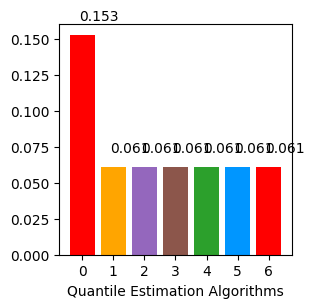

In [97]:
#process results
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
num_methods = len(methods)

#save result dictionary to numpy array
CDF_array = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
rel_error = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
for (i, key) in enumerate(CDF_dict.keys()):
    for (j, variance) in enumerate(CDF_dict[key].keys()):
        for (trial, trial_CDF) in CDF_dict[key][variance].items():
            #record square errors 
            CDF_array[i, j, trial, :] = trial_CDF

#take average of cdf over time and trials for each variance (n_model * n_variance)
cdf_mean_over_variances = np.mean(np.mean(CDF_array[:, :, :, :], axis=3), axis=2)
print(cdf_mean_over_variances)
#take average of cdf over for each trial (n_model * n_variance * n_periods)
cdf_mean_over_trials = np.mean(CDF_array, axis=2)

#plot results
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF']

for (idx, variance) in enumerate(variances):
    print(f'Variance: {variance}')
    #for each variance, barplot mean MSE of each method
    fig, ax = plt.subplots(1, 1, figsize = (3, 3))    
    ax.bar(range(num_methods), cdf_mean_over_variances[:, idx], color=colors, \
           width = 0.8)
    #show number on yaxis
    for i, v in enumerate(cdf_mean_over_variances[:, idx]):
        ax.text(i - 0.1, v + 0.01, f'{v:.3f}', color='black')
    ax.set_xlabel('Quantile Estimation Algorithms')
    ax.set_xticks(range(num_methods))
    ax.set_xticklabels(['ARW', 'V1','Vfull'])
    ax.set_ylabel(r'Mean $|F_t(\widehat{q}_{t,\hat{k}}) - (1-\alpha)|$')
    mpl.rcParams.update({'font.size': 10})
    plt.tight_layout()
    plt.show()
    
    #uncomment to save the figure
    #plt.savefig(f'{DATAPATH}/{figname}_var{variance}.png', dpi=300, bbox_inches='tight')

#TODO: discard the first ~100 periods